<center>
    <p align="center">
        <img src="https://logodownload.org/wp-content/uploads/2017/09/mackenzie-logo-3.png" style="height: 7ch;"><br>
        <h1 align="center">Computer Systems Undergradute Thesis</h1>
        <h2 align="center">Quantitative Analysis of the Impact of Image Pre-Processing on the Accuracy of Computer Vision Models Trained to Identify Dermatological Skin Diseases</a>
        <h4 align="center">Gabriel Mitelman Tkacz</a>
        </h4>
    </p>
</center>

<hr>

In [1]:
import re
import tomllib
from functools import partial
from itertools import permutations
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from pynimbar import loading_animation

from util import (ColorSpaceTransform, DenoiseTransform,
                  EqualizationTransform, NormalizeTransform, evaluate_model,
                  get_model_data)

In [2]:
with open("parameters.toml", "r") as f:
    parameters = tomllib.loads(f.read())

loading_handler = partial(
    loading_animation, break_on_error=True, verbose_errors=True, time_it_live=True
)

alpha = chr(0x03B1)

pprint(parameters)

{'PREPROCESS': {'colorspace': {'source_space': 'RGB', 'target_space': 'HSV'},
                'denoise': {'search_window_size': 19,
                            'template_window_size': 5},
                'normalize': {'mean': 0.4, 'std': 0.2}},
 'TRAINING': {'batch_size': 128,
              'diseased_skin_path': './dataset/diseased/',
              'healthy_skin_path': './dataset/healthy/',
              'learning_rate': 0.0001,
              'num_epochs': 3,
              'num_workers': 12,
              'pin_memory': True,
              'precision_threshold': 0.8,
              'resize_dim': 128,
              'shuffle': True,
              'training_dataset_ratio': 0.8}}


In [3]:
preprocesses = (
    ColorSpaceTransform(**parameters["PREPROCESS"]["colorspace"]),
    DenoiseTransform(**parameters["PREPROCESS"]["denoise"]),
    EqualizationTransform(),
    NormalizeTransform(**parameters["PREPROCESS"]["normalize"]),
)

preprocess_combinations = {
    i: permutations(preprocesses, i) for i in range(2, len(preprocesses) + 1)
}

preprocess_labels = {s.__class__.__name__: re.sub('[^A-Z]', '', s.__class__.__name__)[:-1] for s in preprocesses}
preprocess_labels

{'ColorSpaceTransform': 'CS',
 'DenoiseTransform': 'D',
 'EqualizationTransform': 'E',
 'NormalizeTransform': 'N'}

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
training_ratio = parameters["TRAINING"]["training_dataset_ratio"]
testing_ratio = validation_ratio = round(1 - training_ratio, 1) / 2

print(f"Training ratio: {training_ratio*100}%")
print(f"Testing ratio: {testing_ratio*100}%")
print(f"Validation ratio: {validation_ratio*100}%")

seed = 47
print(f"\nSeed: {seed}")

Training ratio: 80.0%
Testing ratio: 10.0%
Validation ratio: 10.0%

Seed: 47


## Class 0 Model: Images with no pre-processing

In [6]:
(
    base_train_loader,
    base_test_loader,
    base_validation_loader,
) = get_model_data(
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

base_precision = evaluate_model(
    device, base_train_loader, base_test_loader, base_validation_loader
)

print(f"Base precision: {base_precision*100:.1f}%")

if base_precision < parameters["TRAINING"]["precision_threshold"]:
    raise ValueError("The base model did not meet the precision threshold.")

Epoch 1/3, Train Loss: 0.0807, Train Accuracy: 89.4%, Validation Loss: 0.2306, Validation Accuracy: 49.0%
Epoch 2/3, Train Loss: 0.0364, Train Accuracy: 95.3%, Validation Loss: 0.1139, Validation Accuracy: 87.0%
Epoch 3/3, Train Loss: 0.0294, Train Accuracy: 96.1%, Validation Loss: 0.0678, Validation Accuracy: 89.5%
Total training duration: 3.2 minutes
Test Accuracy of the Binary Classification Model: 89.5%
Base precision: 89.5%


## Class 1 Models: Images with only one pre-process

### Class 1.1 Models: Normalizing the image

In [7]:
(
    normalize_train_loader,
    normalize_test_loader,
    normalize_validation_loader,
) = get_model_data(
    [NormalizeTransform(**parameters["PREPROCESS"]["normalize"])],
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

normalize_precision = evaluate_model(
    device, normalize_train_loader, normalize_test_loader, normalize_validation_loader
)

normalize_precision_diff = normalize_precision - base_precision

print(f"\n\nNormalized precision: {normalize_precision*100:.1f}%")
print(
    f"That is an {'upgrade' if normalize_precision_diff > 0 else 'downgrade'} of {normalize_precision_diff*100:.1f}%."
)

Epoch 1/3, Train Loss: 0.0747, Train Accuracy: 90.6%, Validation Loss: 0.1327, Validation Accuracy: 88.0%
Epoch 2/3, Train Loss: 0.0309, Train Accuracy: 96.1%, Validation Loss: 0.0286, Validation Accuracy: 97.0%
Epoch 3/3, Train Loss: 0.0264, Train Accuracy: 96.6%, Validation Loss: 0.0242, Validation Accuracy: 97.0%
Total training duration: 3.4 minutes
Test Accuracy of the Binary Classification Model: 95.5%


Normalized precision: 95.5%
That is an upgrade of 6.0%.


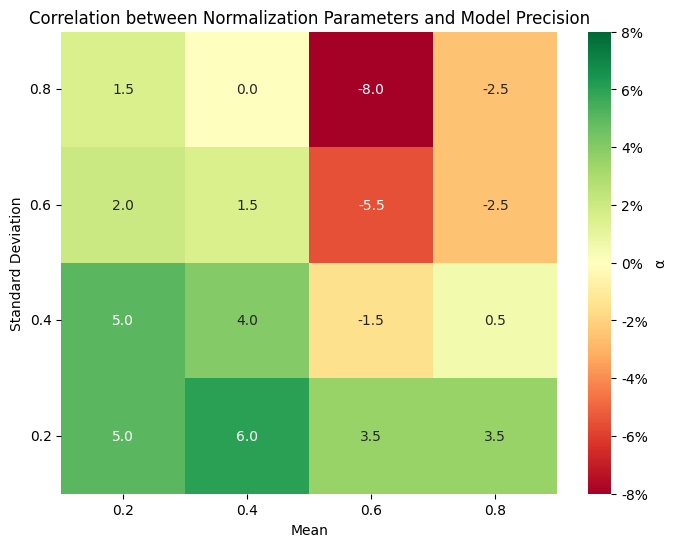

In [8]:
df = pd.read_json("./params/normalize.json")

df["precision"] = df["precision"] - base_precision

pivot_table = df.pivot(index="std", columns="mean", values="precision")

pivot_table = pivot_table.sort_index().sort_index(axis=1).iloc[::-1]

pivot_table_pct = pivot_table * 100

vabs = max(abs(pivot_table_pct.min().min()), abs(pivot_table_pct.max().max()))

plt.figure(figsize=(8, 6))

sns.heatmap(
    pivot_table_pct,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    cbar_kws={"label": alpha, "format": "%.0f%%"},
    vmin=-vabs,
    vmax=vabs,
)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.gca().set_xticklabels([f"{x:.1f}" for x in pivot_table_pct.columns])
plt.gca().set_yticklabels([f"{y:.1f}" for y in pivot_table_pct.index])

plt.title("Correlation between Normalization Parameters and Model Precision")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")

plt.show()

### Class 1.2 Models: Denoising the image

In [9]:
(
    denoise_train_loader,
    denoise_test_loader,
    denoise_validation_loader,
) = get_model_data(
    [DenoiseTransform(**parameters["PREPROCESS"]["denoise"])],
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

denoise_precision = evaluate_model(
    device, denoise_train_loader, denoise_test_loader, denoise_validation_loader
)

denoise_precision_diff = denoise_precision - base_precision

print(f"\n\nDenoised precision: {denoise_precision*100:.1f}%")
print(
    f"That is an {'upgrade' if denoise_precision_diff > 0 else 'downgrade'} of {denoise_precision_diff*100:.1f}%."
)

Epoch 1/3, Train Loss: 0.0865, Train Accuracy: 88.2%, Validation Loss: 0.2458, Validation Accuracy: 48.5%
Epoch 2/3, Train Loss: 0.0392, Train Accuracy: 95.1%, Validation Loss: 0.2288, Validation Accuracy: 56.5%
Epoch 3/3, Train Loss: 0.0387, Train Accuracy: 94.8%, Validation Loss: 0.0307, Validation Accuracy: 96.5%
Total training duration: 4.7 minutes
Test Accuracy of the Binary Classification Model: 94.0%


Denoised precision: 94.0%
That is an upgrade of 4.5%.


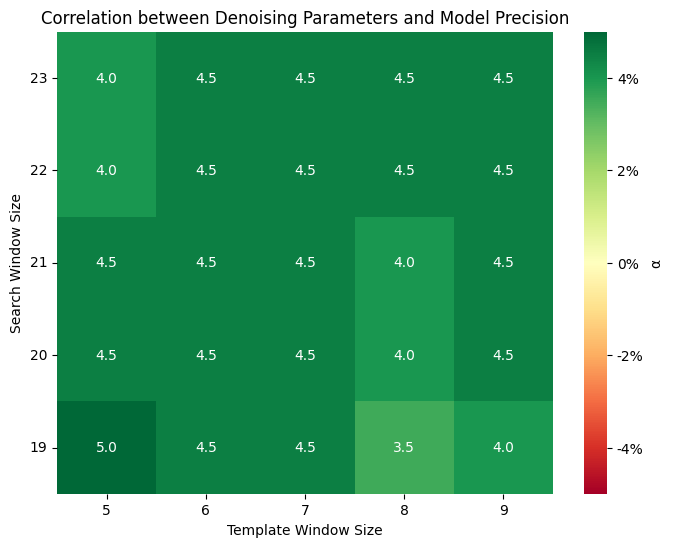

In [10]:
df = pd.read_json("./params/denoise.json")

df["precision"] = df["precision"] - base_precision

pivot_table = df.pivot(
    index="search_window_size", columns="template_window_size", values="precision"
)

pivot_table = pivot_table.sort_index().sort_index(axis=1).iloc[::-1]

pivot_table_pct = pivot_table * 100

vabs = max(abs(pivot_table_pct.min().min()), abs(pivot_table_pct.max().max()))

plt.figure(figsize=(8, 6))

sns.heatmap(
    pivot_table_pct,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    cbar_kws={"label": alpha, "format": "%.0f%%"},
    vmin=-vabs,
    vmax=vabs,
)

plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.gca().set_xticklabels([f"{x:.0f}" for x in pivot_table_pct.columns])
plt.gca().set_yticklabels([f"{y:.0f}" for y in pivot_table_pct.index])

plt.title("Correlation between Denoising Parameters and Model Precision")
plt.xlabel("Template Window Size")
plt.ylabel("Search Window Size")

plt.show()

### Class 1.3 Models: Equalizing the image

In [11]:
(
    equalized_train_loader,
    equalized_test_loader,
    equalized_validation_loader,
) = get_model_data(
    [EqualizationTransform()],
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

equalized_precision = evaluate_model(
    device, equalized_train_loader, equalized_test_loader, equalized_validation_loader
)

equalized_precision_diff = equalized_precision - base_precision

print(f"\n\nEqualized precision: {equalized_precision*100:.1f}%")
print(
    f"That is an {'upgrade' if equalized_precision_diff > 0 else 'downgrade'} of {equalized_precision_diff*100:.1f}%."
)

Epoch 1/3, Train Loss: 0.0802, Train Accuracy: 89.2%, Validation Loss: 0.3328, Validation Accuracy: 48.5%
Epoch 2/3, Train Loss: 0.0243, Train Accuracy: 96.9%, Validation Loss: 0.2212, Validation Accuracy: 64.0%
Epoch 3/3, Train Loss: 0.0304, Train Accuracy: 96.0%, Validation Loss: 0.0461, Validation Accuracy: 95.5%
Total training duration: 3.3 minutes
Test Accuracy of the Binary Classification Model: 94.5%


Equalized precision: 94.5%
That is an upgrade of 5.0%.


### Class 1.4 Models: Changing the colorspace

In [12]:
(
    colorspace_train_loader,
    colorspace_test_loader,
    colorspace_validation_loader,
) = get_model_data(
    [ColorSpaceTransform(**parameters["PREPROCESS"]["colorspace"])],
    training_ratio=training_ratio,
    testing_ratio=testing_ratio,
    validation_ratio=validation_ratio,
    seed=seed,
)

colorspace_precision = evaluate_model(
    device, colorspace_train_loader, colorspace_test_loader, colorspace_validation_loader
)

colorspace_precision_diff = colorspace_precision - base_precision

print(f"\n\nColorspaced precision: {colorspace_precision*100:.1f}%")
print(
    f"That is an {'upgrade' if colorspace_precision_diff > 0 else 'downgrade'} of {colorspace_precision_diff*100:.1f}%."
)

Epoch 1/3, Train Loss: 0.0924, Train Accuracy: 86.3%, Validation Loss: 0.3350, Validation Accuracy: 48.5%
Epoch 2/3, Train Loss: 0.0415, Train Accuracy: 94.6%, Validation Loss: 0.2256, Validation Accuracy: 60.5%
Epoch 3/3, Train Loss: 0.0356, Train Accuracy: 95.6%, Validation Loss: 0.0564, Validation Accuracy: 92.5%
Total training duration: 3.2 minutes
Test Accuracy of the Binary Classification Model: 91.5%


Colorspaced precision: 91.5%
That is an upgrade of 2.0%.


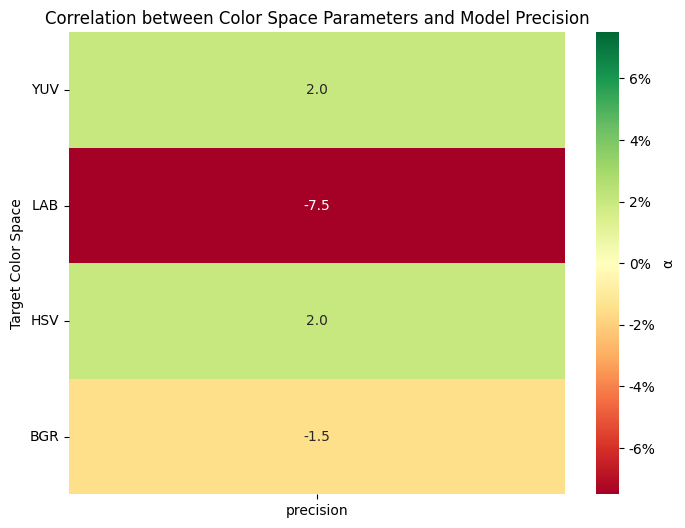

In [13]:
df = pd.read_json("./params/colorspace.json")

df["precision"] = df["precision"] - base_precision

pivot_table = df.set_index("target_space")

pivot_table = pivot_table.sort_index().sort_index(axis=1).iloc[::-1]

pivot_table_pct = pivot_table * 100

vabs = max(abs(pivot_table_pct.min().min()), abs(pivot_table_pct.max().max()))

plt.figure(figsize=(8, 6))

sns.heatmap(
    pivot_table_pct,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    cbar_kws={"label": alpha, "format": "%.0f%%"},
    vmin=-vabs,
    vmax=vabs,
)

plt.xticks(rotation=0)
plt.yticks(rotation=0)

plt.title("Correlation between Color Space Parameters and Model Precision")
plt.ylabel("Target Color Space")

plt.show()

## Class 2 Models: Images with two pre-processes

In [14]:
class2_precisions = {}

for idx, combination in enumerate(preprocess_combinations[2]):
    (
        class2_train_loader,
        class2_test_loader,
        class2_validation_loader,
    ) = get_model_data(
        combination,
        training_ratio=training_ratio,
        testing_ratio=testing_ratio,
        validation_ratio=validation_ratio,
        seed=seed,
    )

    curr_precision = evaluate_model(
        device, class2_train_loader, class2_test_loader, class2_validation_loader, verbose=False
    )
    
    uuid = ", ".join([str(t.__class__.__name__) for t in combination])

    class2_precisions[uuid] = curr_precision

    curr_precision_diff = curr_precision - base_precision

    print(f"\n\nClass 2.{idx+1} {uuid} precision: {curr_precision*100:.1f}%")
    print(
        f"That is an {'upgrade' if curr_precision_diff > 0 else 'downgrade'} of {curr_precision_diff*100:.1f}%."
    )



Class 2.0 ColorSpaceTransform, DenoiseTransform precision: 91.0%
That is an upgrade of 1.5%.


Class 2.1 ColorSpaceTransform, EqualizationTransform precision: 85.0%
That is an downgrade of -4.5%.


Class 2.2 ColorSpaceTransform, NormalizeTransform precision: 92.5%
That is an upgrade of 3.0%.


Class 2.3 DenoiseTransform, ColorSpaceTransform precision: 93.0%
That is an upgrade of 3.5%.


Class 2.4 DenoiseTransform, EqualizationTransform precision: 96.0%
That is an upgrade of 6.5%.


Class 2.5 DenoiseTransform, NormalizeTransform precision: 95.0%
That is an upgrade of 5.5%.


Class 2.6 EqualizationTransform, ColorSpaceTransform precision: 90.0%
That is an upgrade of 0.5%.


Class 2.7 EqualizationTransform, DenoiseTransform precision: 91.0%
That is an upgrade of 1.5%.


Class 2.8 EqualizationTransform, NormalizeTransform precision: 95.0%
That is an upgrade of 5.5%.


Class 2.9 NormalizeTransform, ColorSpaceTransform precision: 81.0%
That is an downgrade of -8.5%.


Class 2.10 NormalizeT

In [15]:
class2_df_data = [
    {
        "transform_1": k.split(", ")[0],
        "transform_2": k.split(", ")[1],
        "precision": v,
        alpha: v - base_precision,
    }
    for k, v in class2_precisions.items()
]
class2_df = pd.DataFrame(class2_df_data).sort_values(alpha, ascending=False).reset_index(drop=True)
class2_df.transform_1 = class2_df.transform_1.apply(lambda x: preprocess_labels[x])
class2_df.transform_2 = class2_df.transform_2.apply(lambda x: preprocess_labels[x])
class2_df

,transform_1,transform_2,precision,α
0,D,E,0.960,0.065
1,D,N,0.950,0.055
2,E,N,0.950,0.055
3,D,CS,0.930,0.035
4,CS,N,0.925,0.030
5,CS,D,0.910,0.015
6,E,D,0.910,0.015
7,E,CS,0.900,0.005
8,CS,E,0.850,-0.045
9,N,D,0.835,-0.060


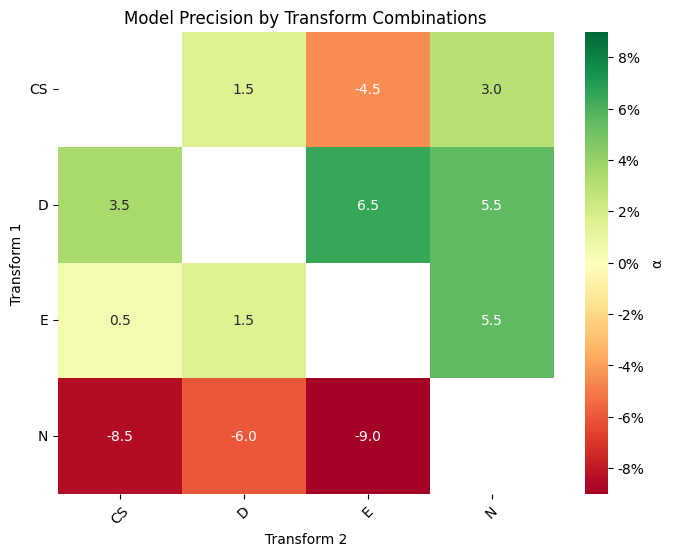

In [16]:
grouped = class2_df.groupby(['transform_1', 'transform_2']).mean()
grouped[alpha] *= 100

vabs = max(abs(grouped.min().min()), abs(grouped.max().max()))

pivot = grouped[alpha].unstack()

plt.figure(figsize=(8, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap="RdYlGn",
    cbar_kws={"label": alpha, "format": "%.0f%%"},
    vmax=vabs,
    vmin=-vabs
)
plt.title('Model Precision by Transform Combinations')
plt.ylabel('Transform 1')
plt.xlabel('Transform 2')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

## Class 3 Models: Images with three pre-processes

In [17]:
class3_precisions = {}

for idx, combination in enumerate(preprocess_combinations[3]):
    (
        class3_train_loader,
        class3_test_loader,
        class3_validation_loader,
    ) = get_model_data(
        combination,
        training_ratio=training_ratio,
        testing_ratio=testing_ratio,
        validation_ratio=validation_ratio,
        seed=seed,
    )

    curr_precision = evaluate_model(
        device, class3_train_loader, class3_test_loader, class3_validation_loader, verbose=False
    )
    
    uuid = "→".join([str(t.__class__.__name__) for t in combination])

    class3_precisions[uuid] = curr_precision

    curr_precision_diff = curr_precision - base_precision

    print(f"\n\nClass 3.{idx+1} {uuid} precision: {curr_precision*100:.1f}%")
    print(
        f"That is an {'upgrade' if curr_precision_diff > 0 else 'downgrade'} of {curr_precision_diff*100:.1f}%."
    )



Class 3.1 ColorSpaceTransform→DenoiseTransform→EqualizationTransform precision: 83.5%
That is an downgrade of -6.0%.


Class 3.2 ColorSpaceTransform→DenoiseTransform→NormalizeTransform precision: 92.5%
That is an upgrade of 3.0%.


Class 3.3 ColorSpaceTransform→EqualizationTransform→DenoiseTransform precision: 86.5%
That is an downgrade of -3.0%.


Class 3.4 ColorSpaceTransform→EqualizationTransform→NormalizeTransform precision: 88.5%
That is an downgrade of -1.0%.


Class 3.5 ColorSpaceTransform→NormalizeTransform→DenoiseTransform precision: 78.0%
That is an downgrade of -11.5%.


Class 3.6 ColorSpaceTransform→NormalizeTransform→EqualizationTransform precision: 86.0%
That is an downgrade of -3.5%.


Class 3.7 DenoiseTransform→ColorSpaceTransform→EqualizationTransform precision: 88.5%
That is an downgrade of -1.0%.


Class 3.8 DenoiseTransform→ColorSpaceTransform→NormalizeTransform precision: 91.5%
That is an upgrade of 2.0%.


Class 3.9 DenoiseTransform→EqualizationTransform→ColorSp

## Class 4 Models: Images with four pre-processes

In [18]:
class4_precisions = {}

for idx, combination in enumerate(preprocess_combinations[4]):
    (
        class4_train_loader,
        class4_test_loader,
        class4_validation_loader,
    ) = get_model_data(
        combination,
        training_ratio=training_ratio,
        testing_ratio=testing_ratio,
        validation_ratio=validation_ratio,
        seed=seed,
    )

    curr_precision = evaluate_model(
        device, class4_train_loader, class4_test_loader, class4_validation_loader, verbose=False
    )
    
    uuid = "➔".join([str(t.__class__.__name__) for t in combination])

    class4_precisions[uuid] = curr_precision

    curr_precision_diff = curr_precision - base_precision

    print(f"\n\nClass 4.{idx+1} {uuid} precision: {curr_precision*100:.1f}%")
    print(
        f"That is an {'upgrade' if curr_precision_diff > 0 else 'downgrade'} of {curr_precision_diff*100:.1f}%."
    )



Class 4.1 ColorSpaceTransform➔DenoiseTransform➔EqualizationTransform➔NormalizeTransform precision: 89.5%
That is an downgrade of 0.0%.


Class 4.2 ColorSpaceTransform➔DenoiseTransform➔NormalizeTransform➔EqualizationTransform precision: 56.5%
That is an downgrade of -33.0%.


Class 4.3 ColorSpaceTransform➔EqualizationTransform➔DenoiseTransform➔NormalizeTransform precision: 94.0%
That is an upgrade of 4.5%.


Class 4.4 ColorSpaceTransform➔EqualizationTransform➔NormalizeTransform➔DenoiseTransform precision: 87.5%
That is an downgrade of -2.0%.


Class 4.5 ColorSpaceTransform➔NormalizeTransform➔DenoiseTransform➔EqualizationTransform precision: 77.5%
That is an downgrade of -12.0%.


Class 4.6 ColorSpaceTransform➔NormalizeTransform➔EqualizationTransform➔DenoiseTransform precision: 77.5%
That is an downgrade of -12.0%.


Class 4.7 DenoiseTransform➔ColorSpaceTransform➔EqualizationTransform➔NormalizeTransform precision: 91.5%
That is an upgrade of 2.0%.


Class 4.8 DenoiseTransform➔ColorSpac

In [22]:
import dill                            #pip install dill --user
filename = 'globalsave.pkl'
dill.dump_session(filename)